### **Install and Import Libraries**

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


# **Load and Pre-process Data**

In [2]:
mean, std = 0.2860, 0.3530

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_full = datasets.FashionMNIST("./data", train=True, download=True, transform=train_tfms)
test_ds    = datasets.FashionMNIST("./data", train=False, download=True, transform=test_tfms)

# Split train into train/val (90/10)
n_val = int(0.1 * len(train_full))
train_ds, val_ds = random_split(train_full, [len(train_full) - n_val, n_val])

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=128)
test_dl  = DataLoader(test_ds,  batch_size=128)

classes = train_full.classes
print("Classes:", classes)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.4MB/s]

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# **Define ANN and CNN Models**

In [3]:
# Simple ANN baseline
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.net(x)

# Advanced CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))


## **Training & Evaluation Utilities**

In [4]:
def train_epoch(model, loader, opt, criterion):
    model.train(); loss_sum=acc_sum=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        acc_sum  += (out.argmax(1)==yb).sum().item()
    return loss_sum/len(loader.dataset), acc_sum/len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval(); loss_sum=acc_sum=0; preds=[]; labels=[]
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = criterion(out, yb)
        loss_sum += loss.item()*xb.size(0)
        acc_sum  += (out.argmax(1)==yb).sum().item()
        preds.append(out.argmax(1).cpu().numpy()); labels.append(yb.cpu().numpy())
    preds, labels = np.concatenate(preds), np.concatenate(labels)
    return loss_sum/len(loader.dataset), acc_sum/len(loader.dataset), preds, labels

def fit(model, train_dl, val_dl, epochs=20, lr=1e-3):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    hist = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
    best_wts=None; best_val=float("inf")
    for ep in range(epochs):
        tl,ta = train_epoch(model, train_dl, opt, criterion)
        vl,va,_,_ = eval_model(model, val_dl, criterion)
        scheduler.step()
        hist["train_loss"].append(tl); hist["val_loss"].append(vl)
        hist["train_acc"].append(ta);  hist["val_acc"].append(va)
        if vl<best_val: best_val=vl; best_wts=model.state_dict().copy()
        print(f"Epoch {ep+1:02d}: TL={tl:.3f} TA={ta:.3f} VL={vl:.3f} VA={va:.3f}")
    model.load_state_dict(best_wts)
    return hist


# **Train the Advanced CNN**

In [5]:
cnn = CNN().to(device)
hist = fit(cnn, train_dl, val_dl, epochs=25, lr=5e-4)

Epoch 01: TL=0.594 TA=0.784 VL=0.391 VA=0.860
Epoch 02: TL=0.424 TA=0.843 VL=0.346 VA=0.873
Epoch 03: TL=0.375 TA=0.861 VL=0.319 VA=0.880
Epoch 04: TL=0.352 TA=0.871 VL=0.299 VA=0.888
Epoch 05: TL=0.327 TA=0.880 VL=0.278 VA=0.898
Epoch 06: TL=0.314 TA=0.885 VL=0.264 VA=0.902
Epoch 07: TL=0.297 TA=0.890 VL=0.269 VA=0.904
Epoch 08: TL=0.286 TA=0.896 VL=0.251 VA=0.907
Epoch 09: TL=0.275 TA=0.899 VL=0.244 VA=0.911
Epoch 10: TL=0.269 TA=0.902 VL=0.246 VA=0.910
Epoch 11: TL=0.260 TA=0.905 VL=0.243 VA=0.913
Epoch 12: TL=0.252 TA=0.908 VL=0.236 VA=0.916
Epoch 13: TL=0.244 TA=0.911 VL=0.235 VA=0.914
Epoch 14: TL=0.237 TA=0.913 VL=0.231 VA=0.918
Epoch 15: TL=0.235 TA=0.916 VL=0.220 VA=0.923
Epoch 16: TL=0.225 TA=0.918 VL=0.220 VA=0.919
Epoch 17: TL=0.222 TA=0.919 VL=0.212 VA=0.924
Epoch 18: TL=0.216 TA=0.922 VL=0.212 VA=0.921
Epoch 19: TL=0.213 TA=0.921 VL=0.206 VA=0.925
Epoch 20: TL=0.206 TA=0.925 VL=0.204 VA=0.928
Epoch 21: TL=0.206 TA=0.926 VL=0.210 VA=0.925
Epoch 22: TL=0.203 TA=0.925 VL=0.2

## **Plot Training Curves**

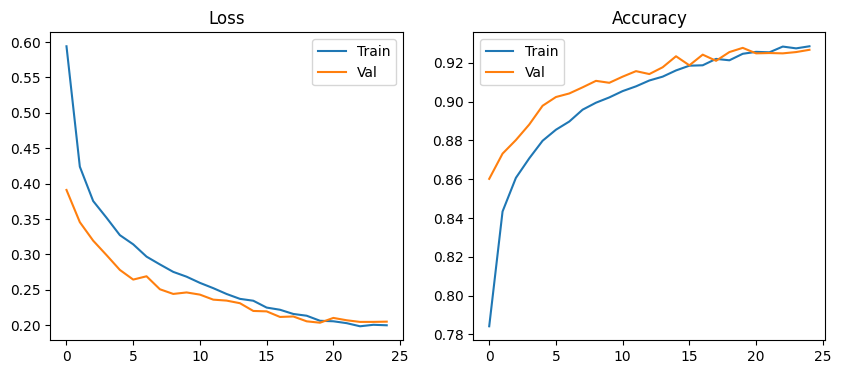

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train")
plt.plot(hist["val_loss"], label="Val")
plt.title("Loss"); plt.legend()
plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train")
plt.plot(hist["val_acc"], label="Val")
plt.title("Accuracy"); plt.legend()
plt.show()


# **Evaluate on Test Set**

In [7]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, preds, labels = eval_model(cnn, test_dl, criterion)
print(f"Test Loss={test_loss:.3f}  Test Acc={test_acc:.3f}")

print("\nClassification Report:\n",
      classification_report(labels, preds, target_names=classes))


Test Loss=0.205  Test Acc=0.929

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.88      0.91      0.89      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.88      0.91      0.90      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.81      0.76      0.78      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# **Confusion Matrix and Misclassified Images**

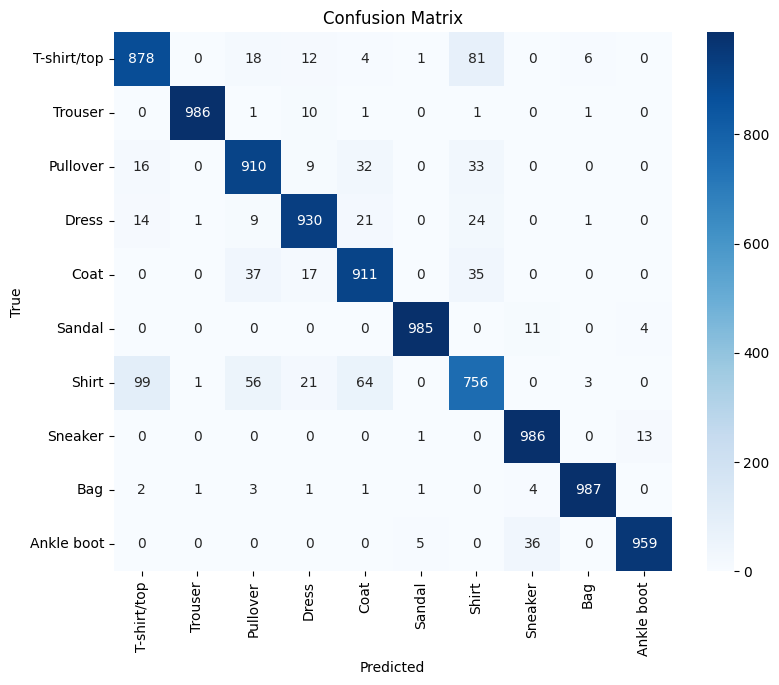

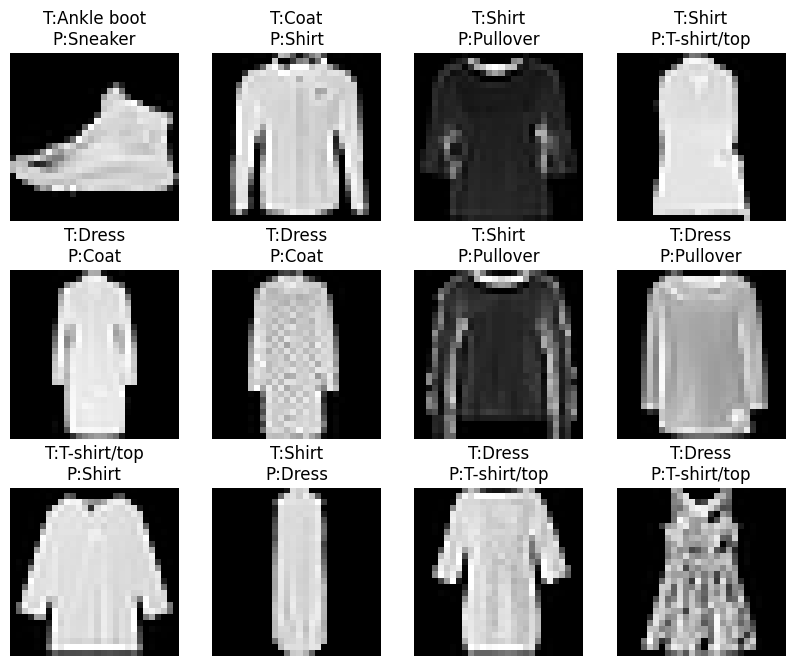

In [8]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# show a few misclassified examples
mis_idx = np.where(preds != labels)[0]
samples = np.random.choice(mis_idx, 12, replace=False)
plt.figure(figsize=(10,8))
for i, idx in enumerate(samples):
    img, true = test_ds[idx]
    pred = preds[idx]
    plt.subplot(3,4,i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"T:{classes[true]}\nP:{classes[pred]}")
    plt.axis("off")
plt.show()


## **Save Model and Summary**

In [9]:
torch.save(cnn.state_dict(), "cnn_fashion_mnist.pt")
print("Model saved as cnn_fashion_mnist.pt")


Model saved as cnn_fashion_mnist.pt


## **Train the ANN for Comparison**

In [10]:
ann = ANN().to(device)
hist_ann = fit(ann, train_dl, val_dl, epochs=20, lr=1e-3)
test_loss, test_acc, preds, labels = eval_model(ann, test_dl, nn.CrossEntropyLoss())
print(f"ANN Test Accuracy = {test_acc:.3f}")


Epoch 01: TL=0.650 TA=0.777 VL=0.484 VA=0.823
Epoch 02: TL=0.505 TA=0.816 VL=0.432 VA=0.841
Epoch 03: TL=0.461 TA=0.834 VL=0.411 VA=0.850
Epoch 04: TL=0.440 TA=0.840 VL=0.395 VA=0.860
Epoch 05: TL=0.421 TA=0.846 VL=0.398 VA=0.853
Epoch 06: TL=0.411 TA=0.851 VL=0.378 VA=0.861
Epoch 07: TL=0.397 TA=0.853 VL=0.367 VA=0.864
Epoch 08: TL=0.387 TA=0.858 VL=0.354 VA=0.871
Epoch 09: TL=0.374 TA=0.863 VL=0.356 VA=0.869
Epoch 10: TL=0.365 TA=0.867 VL=0.343 VA=0.874
Epoch 11: TL=0.356 TA=0.870 VL=0.337 VA=0.875
Epoch 12: TL=0.348 TA=0.872 VL=0.332 VA=0.876
Epoch 13: TL=0.342 TA=0.875 VL=0.327 VA=0.878
Epoch 14: TL=0.334 TA=0.878 VL=0.329 VA=0.880
Epoch 15: TL=0.327 TA=0.881 VL=0.319 VA=0.881
Epoch 16: TL=0.322 TA=0.881 VL=0.317 VA=0.885
Epoch 17: TL=0.317 TA=0.882 VL=0.320 VA=0.880
Epoch 18: TL=0.312 TA=0.884 VL=0.310 VA=0.884
Epoch 19: TL=0.311 TA=0.886 VL=0.314 VA=0.885
Epoch 20: TL=0.311 TA=0.885 VL=0.313 VA=0.885
ANN Test Accuracy = 0.884
